# Adam Thomson - PHY 573 - Grover's Sudoku

### Solving Sudoku using Grover's Algorithm
This is a continuation of the qiskit tutorial for Grover's algorithm, in section 4.1 https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/grover.ipynb

In [78]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from math import gcd
from numpy.random import randint
from IPython.display import Math, HTML
from qiskit import QuantumCircuit as QCir, \
                   QuantumRegister as QReg, \
                   ClassicalRegister as CReg, \
                   transpile
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

# Initialize local simulator
sampler = AerSimulator()

# Declare shortcut function
def dm(x):
    return display(Math(x))

In this simplified version of sudoku, we want to use binary to solve a 2x2 square. We can apply Grover's algorithm here by modeling the problem as a 4-qubit search space where correct solutions should be "marked" as correct.

In [79]:
# Setup the problem statement
dm(r"""
\def\arraystretch{1.5}
   \begin{array}{c|c}
   v_0 & v_1 \\ \hline
   v_2 & v_3 \\
\end{array}
""")
dm(r"\text{With the normal rules of Sudoku:}")
dm(r"v_0 \neq v_1; v_0 \neq v_2; v_2 \neq v_3; v_1 \neq v_3")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [80]:
# Define the rules as a list of clauses for enforced inequality
clause_list = [[0,1],[0,2],[1,3],[2,3]]

In [81]:
# Define the XOR gate to help construct the circuit
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

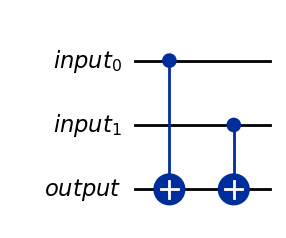

In [97]:
# Demonstrate the XOR operator
# We will use separate registers to name the bits
in_qubits = QReg(2, name='input')
out_qubit = QReg(1, name='output')
qc = QCir(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw(output="mpl")

We now setup 2 quantum registers with 4 qubits each. One register will be measured to be used as the solution to our puzzle (variable qubits); the other register will be used to check our clauses by passing each qubit as the output of a XOR gate using the bits defined in the clauses as inputs.

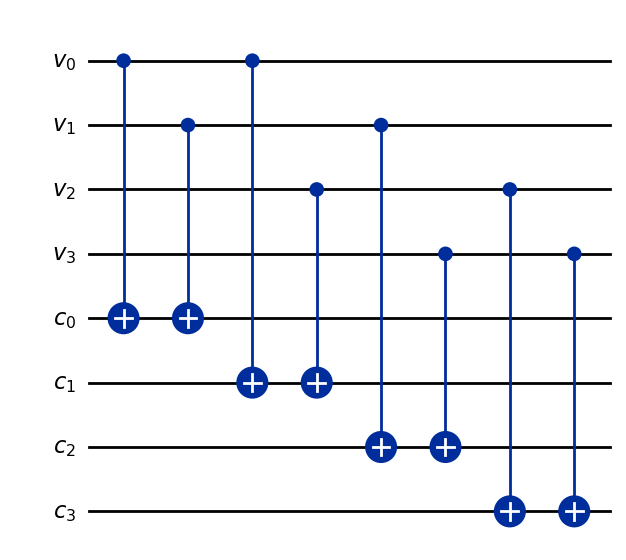

In [83]:
# Encode the clauses with XOR gates
var_qubits = QReg(4, name='v')      # Variables measured for a solution
clause_qubits = QReg(4, name='c')  # Store the clause checks

# Create a quantum circuit with both registers
sudoku_qc = QCir(var_qubits, clause_qubits)

# Check each clause with a XOR gate
for i, clause in enumerate(clause_list):
    XOR(sudoku_qc, clause[0], clause[1], clause_qubits[i])

sudoku_qc.draw(output="mpl")

With this circuit, our variable qubits will be in a correct solution state only when all qubits in the clause register are equal to 1. Therefore, we can use another qubit to check if our variables are in a solution state by application of a multi-controlled-Toffoli gate.

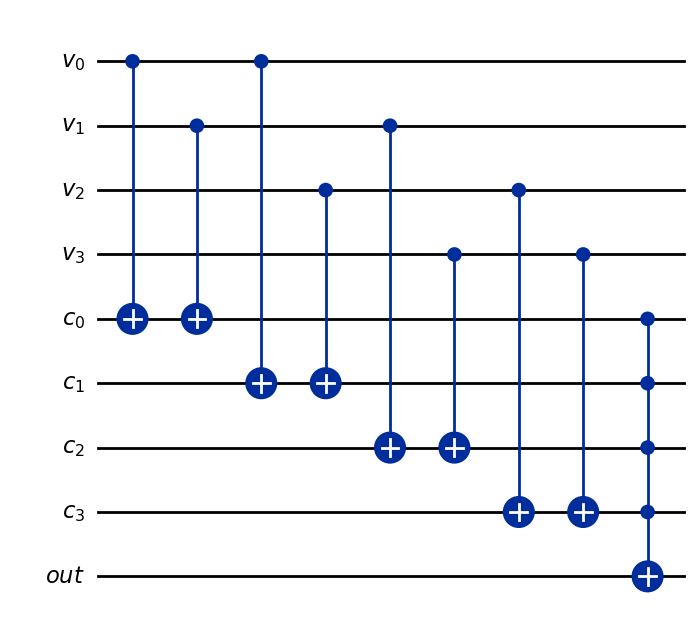

In [84]:
# Add an output qubit with a MCX gate
# Add a new "output" qubit and reconstruct the circuit
output_qubit = QReg(1, name='out')
sudoku_qc = QCir(var_qubits, clause_qubits, output_qubit)

for i, clause in enumerate(clause_list):
    XOR(sudoku_qc, clause[0], clause[1], clause_qubits[i])

sudoku_qc.mcx(clause_qubits, output_qubit)

sudoku_qc.draw(output="mpl")

At the end of this circuit, assuming we initilized to |0>, we can be confident that if the output qubit is |0> then our variables are not in a correct solution, and if it is |1> then our variables are a correct solution.

### Using this for Grover's Algorithm

Now we need to bring all these pieces together, along with the new concept of "uncomputing", to fully implement Grover's algorithm to find a solution.

In [85]:
# Restate the problem using all qubit registers
dm(r"\text{To move forward, we need to determine what the oracle function for this will look like.}")
dm(r"\text{Thus, we must construct a circuit that will perform the following transformation:}")
dm(r"\text{Where } \ket{x} \text{ is our variable register, } \ket{0} \text{ is our clause register abbreviated to } \ket{0} = \ket{00..0}")
dm(r"U_\omega \ket{x} \ket0 \ket{\text{out}_0} = \ket{x} \ket0 \ket{\text{out}_0 \oplus f(x)}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [86]:
# Continue solving for U_w
dm(r"\text{Let's see what happens if we use } \ket{\text{out}_0} = \ket{-}")
dm(r"U_\omega \ket{x} \ket0 \ket{-} = U_\omega \ket{x} \ket0 \otimes \frac1{\sqrt2}(\ket0 - \ket1)")
dm(r"\qquad = \ket{x} \ket0 \otimes \frac1{\sqrt2} ( \ket{0 \oplus f(x)} - \ket{1 \oplus f(x)} )")
dm(r"\text{For incorrect solutions } (f(x) = 0) \text{, nothing is changed}:")
dm(r"\qquad = \ket{x} \ket0 \otimes \frac1{\sqrt2} (\ket0 - \ket1)")
dm(r"\qquad = \ket{x} \ket0 \ket{-}")
dm(r"\text{For correct solutions } (f(x) = 1) \text{, we introduce a negative phase:}")
dm(r"\qquad = \ket{x} \ket0 \otimes - \frac1{\sqrt2} (\ket0 - \ket1)")
dm(r"\qquad = - \ket{x} \ket0 \ket{-}")
dm(r"\text{This means that we have a functioning oracle defined by}")
dm(r"""U_\omega \ket{x} \ket0 \ket{-} = \begin{cases}
\ket{x} \ket0 \ket{-} &\text{for } x \neq \omega \\
-\ket{x} \ket0 \ket{-} &\text{for } x = \omega
\end{cases}""") 

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

To ensure that our variable qubits are in a correct congiguration, we need to use "uncomputing" to get our clause register qubits back to |0>. This can be achieved by repeating the same XOR gates as before. If the previous gates flipped a clause qubit to |1> then the same gates will flip it back to |0>; and if the first gates did not flip the qubit then repeating them will continue to leave it unaffected.

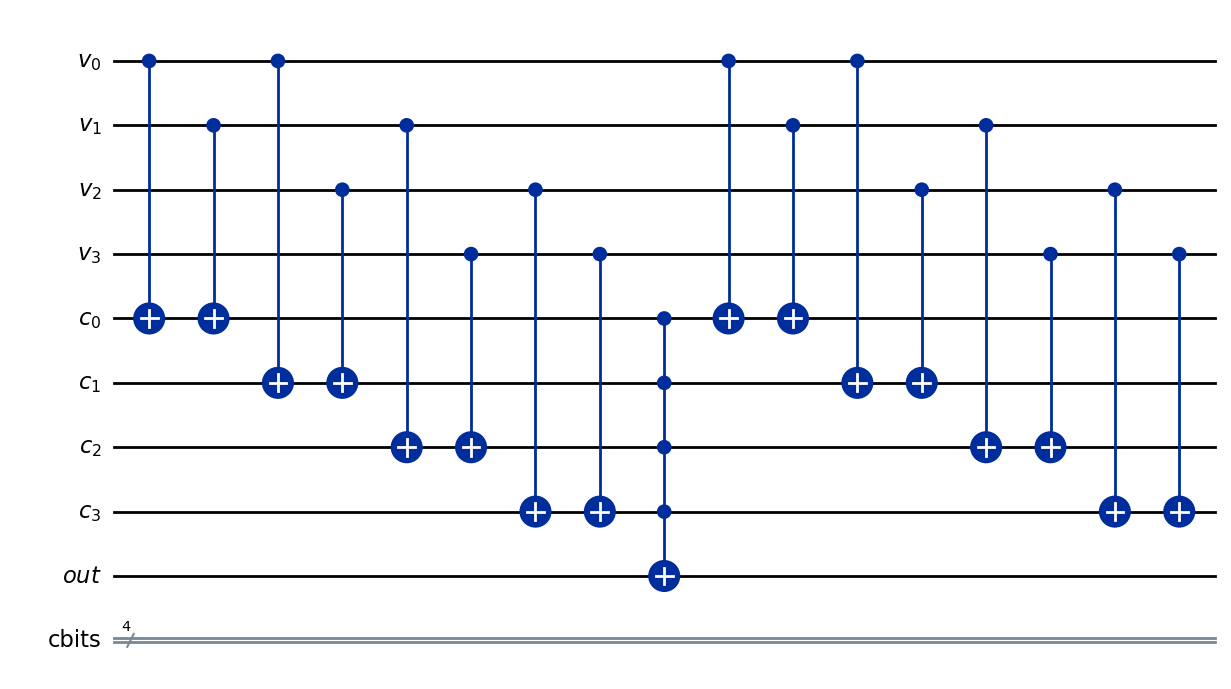

In [93]:
# Build the full circuit for U_w
# Create a classical register to measure to
cbits = CReg(4, name='cbits')
sudoku_qc = QCir(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, clause_qubits, output_qubit):
    # Compute clauses
    for i, clause in enumerate(clause_list):
        XOR(qc, clause[0], clause[1], clause_qubits[i])
    
    # Multi-controlled X gate, clauses as controls and output as target
    qc.mcx(clause_qubits, output_qubit)

    # Uncompute the clases to reset them back to 0
    for i, clause in enumerate(clause_list):
        XOR(qc, clause[0], clause[1], clause_qubits[i])

sudoku_oracle(sudoku_qc, clause_list, clause_qubits, output_qubit)
sudoku_qc.draw(output="mpl")

In [88]:
# Summarize the circuit output
dm(r"\text{Therefore, if we initialize } \ket{\text{out}_0} = \ket{-} \text{, at the end of this circuit our state is:}")
dm(r""" \ket{\psi} = U_\omega \ket{x} \ket0 \ket{-} = \begin{cases}
\ket{x} \ket0 \ket{-} &\text{for } x \neq \omega \\
-\ket{x} \ket0 \ket{-} &\text{for } x = \omega
\end{cases}
""")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Experimentation

We now use a local simulator to run this oracle within Grover's algorithm and examine the results. Note that the tutorial applies the oracle and diffusion function twice without explanation, let's calculate why.

In [89]:
# Figure out optimal number of iterations for algorithm
dm(r"\text{We established previously the equation for optimal } t:")
dm(r"t = \lfloor \frac{\pi}4 \sqrt{\frac{N}{m}} \rfloor")
dm(r"\text{In this case, } N=16, \text{ but what about } m?")
dm(r"\text{Intuitively, we can figure out that it is 2, but what happens if we assume a unique solution?}")
dm(r"\text{If } m=2: t= \lfloor \frac{\pi}4 \sqrt{\frac{16}{2}} \rfloor = \lfloor \frac{\pi}{\sqrt2} \rfloor = 2")
dm(r"\text{If } m=1: t= \lfloor \frac{\pi}4 \sqrt{\frac{16}{1}} \rfloor = \lfloor \pi \rfloor = 3")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Interesting! Let's examine the differences in results if we use t=2 or t=3 when running on a simulator

In [90]:
# Copy diffuser function from tutorial
def diffuser(nqubits):
    qc = QCir(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    # Replace deprecated mcz
    qc.compose(MCMT(ZGate(), nqubits - 1, 1), inplace=True)
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

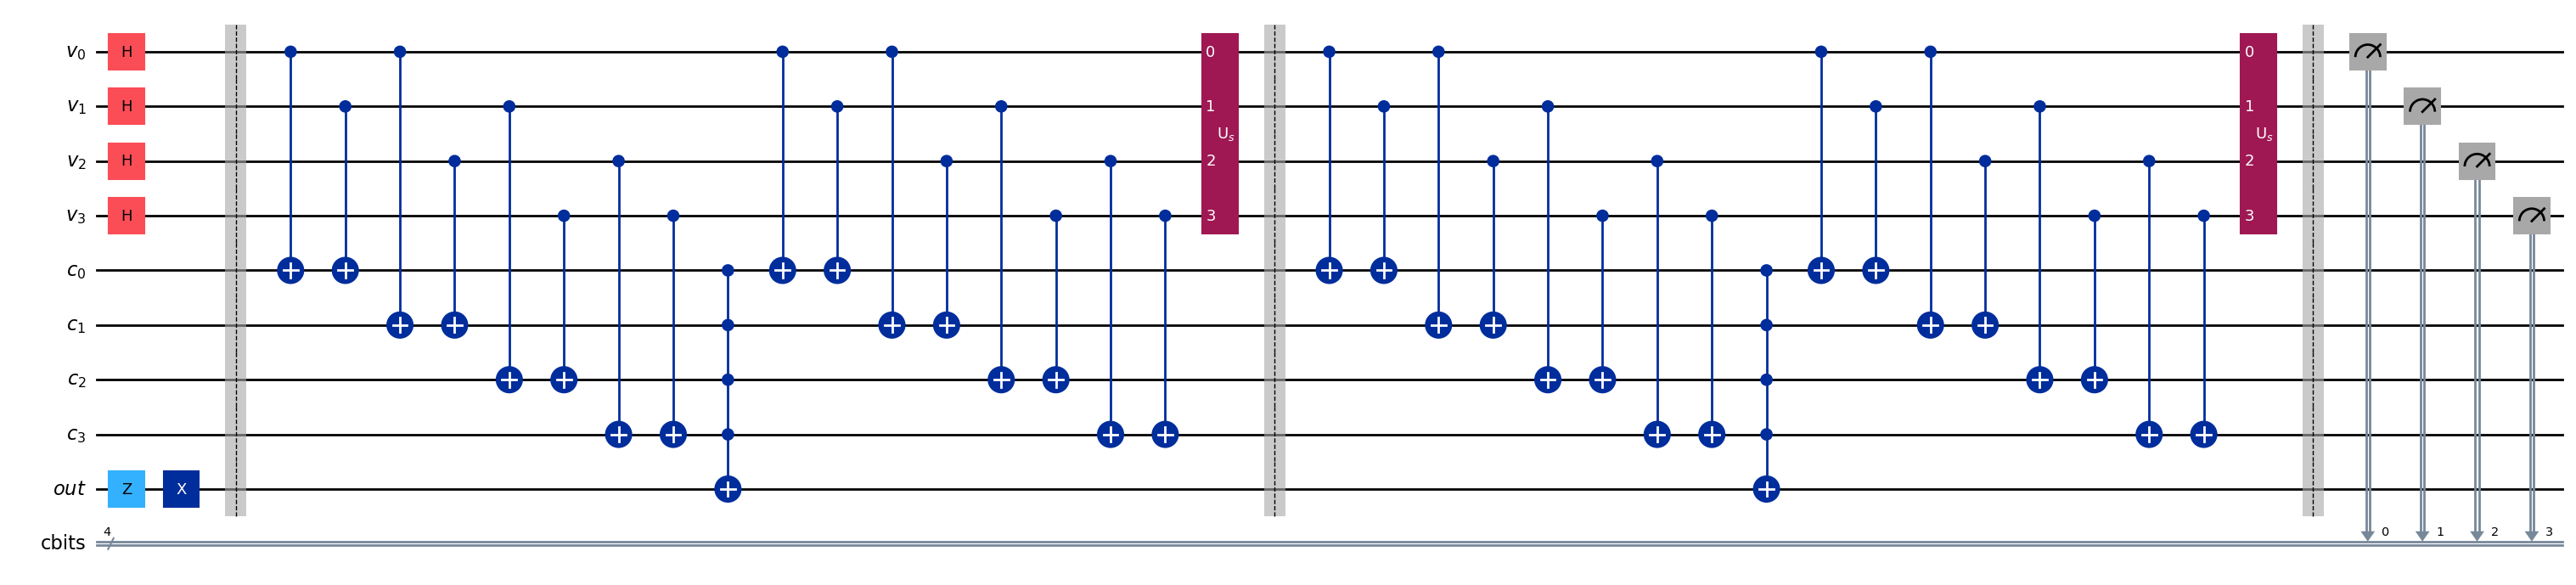

In [91]:
# Create full Grover Sudoku circuit
var_qubits = QReg(4, name='v')
clause_qubits = QReg(4, name='c')
output_qubit = QReg(1, name='out')
cbits = CReg(4, name='cbits')
grover_sudoku = QCir(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize out to |->
grover_sudoku.z(output_qubit)
grover_sudoku.x(output_qubit)
# Initialize var qubits to |+>
grover_sudoku.h(var_qubits)

# Finished circuit setup
grover_sudoku.barrier()

t = 2 # From above, try changing this to 3!
for _ in range(t):
    # Apply the oracle function
    sudoku_oracle(grover_sudoku, clause_list, clause_qubits, output_qubit)
    # Apply the multi-qubit diffuser
    grover_sudoku.append(diffuser(4), [0,1,2,3])
    grover_sudoku.barrier()

grover_sudoku.measure(var_qubits, cbits)
grover_sudoku.draw(fold=-1, output="mpl")

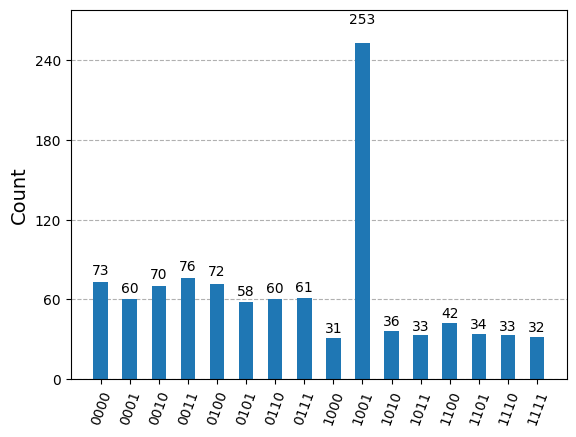

In [92]:
# Plot the results
transpiled_qc = transpile(grover_sudoku, sampler)
result = sampler.run(transpiled_qc).result()
plot_histogram(result.get_counts())

Regardless of if we pick t=2 or t=3, we see that |1001> is the most probable measurement, which is a correct solution! However, when t=3, we see that the probability of measuring any other value is significantly higher than when t=2. We exexpect a non-0 probability of measuring incorrect values because we are unable to align our state perfectly with |w>.

An interesting result is that we fail to see the other correct solution "0110" have an elevated probability of measurement. In theory, there should be equal measurements of "0110" and "1001", but diagnosing this result is beyond the scope of this exercise.

In [102]:
# Describe our results
dm(r"\text{An important step when using Grover's algorithm is verifying the result, and repeating the algorithm if it returned an incorrect result.}")
dm(r"\text{Let's examine the case when we measure the most probable result, } 1001")
dm(r"""\text{This gives us the following sudoku board} \\\\
\def\arraystretch{1.5}
   \begin{array}{c|c}
   1 & 0 \\ \hline
   0 & 1 \\
\end{array}
""")
dm(r"\text{Indeed, all of our clauses hold true because } 0 \neq 1")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Thus, we have used Grover's algorithm to solve the binary sudoku board!